In [1]:
import sys
sys.path.append('/home/jingpei/Desktop/CtRNet-robot-pose-estimation')

import multiprocessing as mp
import os
import time

from PIL import Image

import cv2
import numpy as np
import torch

import torchvision
import matplotlib.pyplot as plt
import glob

from imageloaders.DREAM import ImageDataLoaderSynthetic


from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import kornia


from utils import *



In [2]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.n_kp = 12
args.scale = 0.5
args.lim=[-1., 1., -1., 1.]
args.height = 480 
args.width = 640
args.base_dir = '/home/jingpei/Desktop/CtRNet-robot-pose-estimation'
#args.data_folder = '/media/jingpei/DATA/DREAM/data/synthetic/panda_synth_train_dr'
args.data_folder = '/media/jingpei/DATA/DREAM/data/synthetic/panda_synth_test_photo'

args.use_gpu = True
args.batch_size = 4

if args.use_gpu:
    device = "cuda"
else:
    device = "cpu"


args.fx = -320.
args.fy = -320.
args.px = 320.
args.py = 240.
# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale
intrinsics = np.array([[  args.fx   ,    0.        ,  args.px  ],
                       [  0.        ,    args.fy   ,  args.py  ],
                       [  0.        ,    0.        ,   1.      ]])

K = torch.tensor(intrinsics, device=device, dtype=torch.float)


In [3]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#torch.multiprocessing.set_start_method('spawn')

#dataset = ImageDataLoader(data_file = args.data_file, data_dir = args.data_dir, trans_to_tensor = trans_to_tensor)
#dataloader = DataLoader(dataset, batch_size=args.batch_size, num_workers= 6, shuffle=True)
dataset = ImageDataLoaderSynthetic(data_folder = args.data_folder, scale = args.scale, trans_to_tensor = trans_to_tensor)
dataloader = DataLoader(dataset, batch_size=args.batch_size, num_workers= 6, shuffle=True)

# generate ground truth

In [4]:
from models.robot_arm import PandaArm
from models.BPnP import batch_project
robot = PandaArm(urdf_file = os.path.join(args.base_dir,"urdfs/Panda/panda.urdf"))

In [5]:
data = next(iter(dataloader))
#data = dataset.__getitem__(0)

if args.use_gpu:
    if isinstance(data, list):
        data = [d.cuda() for d in data]
    else:
        data = data.cuda()

img, joint_angle, base_to_cam = data

In [6]:
# generate ground truth

#mask_list_gt = list()
points_2d_gt_list = list()
points_3d_list = list()
for b in range(img.shape[0]):
    #baxter_mesh = panda_renderer.get_robot_mesh(joint_angle[b].cpu().squeeze())
    #rendered_image = panda_renderer.silhouette_renderer(meshes_world=baxter_mesh, R = base_to_cam[b,:3,:3].T.unsqueeze(0), T = base_to_cam[b,:3,3].unsqueeze(0))
    #mask_list_gt.append(rendered_image[..., 3])

    points = robot.get_3d_keypoints(joint_angle[b].cpu().squeeze())
    points_3d = torch.from_numpy(points).float().to(device)
    points_3d_list.append(points_3d[None])
    points_2d_gt = batch_project(base_to_cam[b,:3,:4][None], points_3d, K, angle_axis=False)
    points_2d_gt_list.append(points_2d_gt)


#mask_batch = torch.cat(mask_list_gt,0)
points_2d_gt_batch = torch.cat(points_2d_gt_list,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


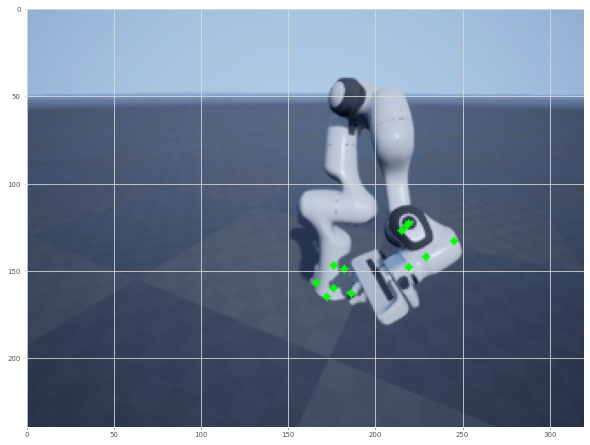

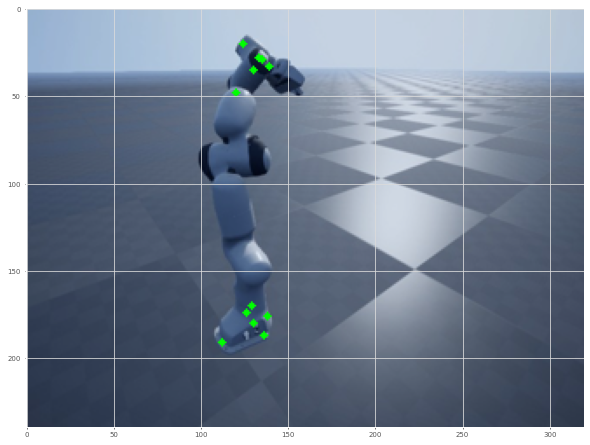

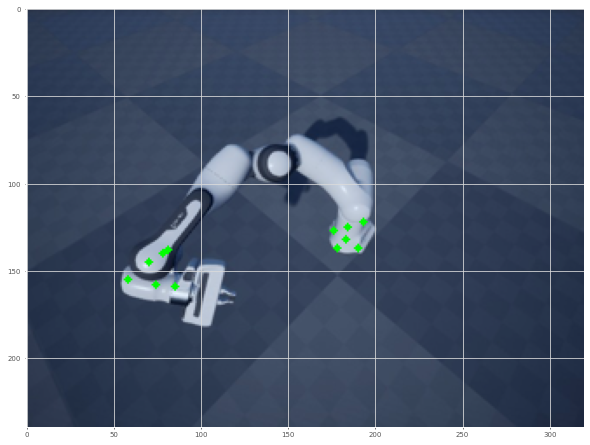

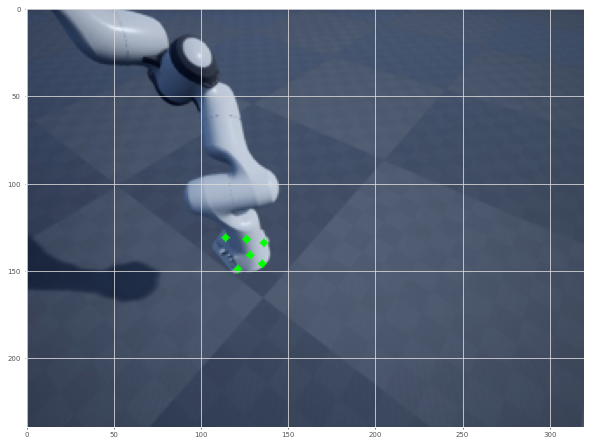

In [7]:
for b in range(img.shape[0]):
    img_np = to_numpy_img(img[b])
    img_np = overwrite_image(img_np,points_2d_gt_batch[b].detach().cpu().numpy().squeeze().astype(int), color=(0,255,0),point_size=2)
    # set size
    plt.figure(figsize=(10,10))
    plt.imshow(img_np)


In [8]:
from models.BPnP import BPnP_m3d
bpnp = BPnP_m3d.apply

In [9]:
bpnp(points_2d_gt_batch, torch.cat(points_3d_list,0),K)

tensor([[-1.7631,  1.1051,  0.7040, -0.1072, -0.2669,  1.0669],
        [-0.8181, -2.3093, -1.3585,  0.2036, -0.4244,  1.1180],
        [-2.3464,  0.9973,  0.3213, -0.1827, -0.0971,  1.2512],
        [-0.8744,  2.6360,  0.9376,  0.2018, -0.1389,  1.0388]],
       device='cuda:0')

In [10]:
base_to_cam

tensor([[[ 0.4359, -0.9000, -0.0000, -0.1072],
         [-0.3808, -0.1844,  0.9061, -0.2668],
         [-0.8155, -0.3949, -0.4232,  1.0667],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[-0.7771,  0.6294, -0.0000,  0.2037],
         [ 0.3063,  0.3781,  0.8736, -0.4246],
         [ 0.5499,  0.6789, -0.4866,  1.1185],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.6940, -0.7200, -0.0000, -0.1826],
         [-0.5847, -0.5636,  0.5835, -0.0971],
         [-0.4201, -0.4049, -0.8121,  1.2512],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[-0.8013, -0.5982, -0.0000,  0.2017],
         [-0.4639,  0.6214,  0.6315, -0.1388],
         [-0.3778,  0.5060, -0.7754,  1.0385],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')

# shared encoder

In [11]:
from models.keypoint_seg_resnet import KeyPointSegNet

keypoint_seg_predictor = KeyPointSegNet(args, use_gpu=args.use_gpu)
if args.use_gpu:
    keypoint_seg_predictor = keypoint_seg_predictor.cuda()


In [12]:
data = next(iter(dataloader))

if args.use_gpu:
    if isinstance(data, list):
        data = [d.cuda() for d in data]
    else:
        data = data.cuda()

img, joint_angle, base_to_cam = data

In [13]:
points_2d, segmentation = keypoint_seg_predictor(img)
points_2d.shape

torch.Size([4, 12, 2])

In [14]:
segmentation.shape

torch.Size([4, 1, 240, 320])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


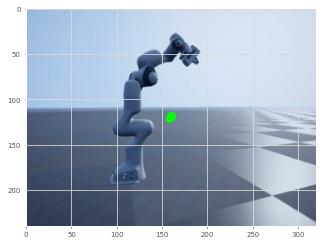

In [15]:
img_np = to_numpy_img(img[0])
img_np = overwrite_image(img_np,points_2d[0].detach().cpu().numpy().squeeze().astype(int), color=(0,255,0),point_size=4)
plt.imshow(img_np)

In [16]:
img_ref = torch.sigmoid(segmentation)
img_ref.shape

torch.Size([4, 1, 240, 320])

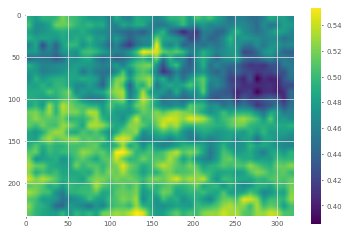

In [17]:
plt.imshow(img_ref[0].squeeze().detach().cpu().numpy())
plt.colorbar()

In [18]:
from models.robot_arm import PandaArm
from models.mesh_renderer import RobotMeshRenderer
from pytorch3d.structures import Meshes

urdf_file = os.path.join(args.base_dir,"urdfs/Panda/panda.urdf")
panda_arm = PandaArm(urdf_file=urdf_file)

focal_length = [-args.fx,-args.fy]
principal_point = [args.px, args.py]
image_size = [args.height,args.width]
mesh_files = [args.base_dir + "/urdfs/Panda/meshes/visual/link0/link0.obj",
              args.base_dir + "/urdfs/Panda/meshes/visual/link1/link1.obj",
              args.base_dir + "/urdfs/Panda/meshes/visual/link2/link2.obj",
              args.base_dir + "/urdfs/Panda/meshes/visual/link3/link3.obj",
              args.base_dir + "/urdfs/Panda/meshes/visual/link4/link4.obj",
              args.base_dir + "/urdfs/Panda/meshes/visual/link5/link5.obj",
              args.base_dir + "/urdfs/Panda/meshes/visual/link6/link6.obj",
              args.base_dir + "/urdfs/Panda/meshes/visual/link7/link7.obj",
              args.base_dir + "/urdfs/Panda/meshes/visual/hand/hand.obj",
             ]
            
panda_renderer = RobotMeshRenderer(
    focal_length=focal_length, principal_point=principal_point, image_size=image_size, 
    robot=panda_arm, mesh_files=mesh_files, device=device)

In [25]:
import models.BPnP as BPnP
# generate ground truth
mask_list_gt = list()
points_2d_gt_list = list()
for b in range(img.shape[0]):
    baxter_mesh = panda_renderer.get_robot_mesh(joint_angle[b].cpu().squeeze())
    rendered_image = panda_renderer.silhouette_renderer(meshes_world=baxter_mesh, R = base_to_cam[b,:3,:3].T.unsqueeze(0), T = base_to_cam[b,:3,3].unsqueeze(0))
    mask_list_gt.append(rendered_image[..., 3])

    points = panda_arm.get_3d_keypoints(joint_angle[b].cpu().squeeze())
    points_3d = torch.from_numpy(points).float().to(device)
    points_2d_gt = BPnP.batch_project(base_to_cam[b,:3,:4][None], points_3d, K, angle_axis=False)
    points_2d_gt_list.append(points_2d_gt)

mask_batch = torch.cat(mask_list_gt,0)
points_2d_gt_batch = torch.cat(points_2d_gt_list,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'GT mask')

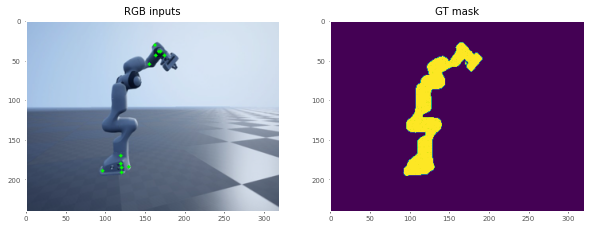

In [26]:
plt.figure(figsize=(10, 10))

img_np = to_numpy_img(img[0])
img_np = overwrite_image(img_np,points_2d_gt_batch[0].detach().cpu().numpy().squeeze().astype(int), color=(0,255,0),point_size=2)

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.grid(False)
plt.title("RGB inputs")

plt.subplot(1, 2, 2)
plt.imshow(mask_batch[0].squeeze().cpu().detach().numpy())
plt.grid(False)
plt.title("GT mask")

In [27]:
criterionMSE_sum = torch.nn.MSELoss(reduction='sum')
loss_mse = criterionMSE_sum(rendered_image[..., 3], img_ref.squeeze(1).clone().detach())
loss_mse

/home/jingpei/anaconda3/envs/pytorch_ros/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4, 240, 320])) that is different to the input size (torch.Size([1, 240, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(76220.7188, device='cuda:0')

In [29]:
criterionMSE_mean = torch.nn.MSELoss(reduction='mean')
#loss = criterionMSE(points_2d_batch, points_2d_proj)
loss_reproj = criterionMSE_mean(points_2d, points_2d_gt_batch)
loss_reproj

tensor(2535.4097, device='cuda:0', grad_fn=<MseLossBackward0>)

In [32]:
criterionBCE = torch.nn.BCEWithLogitsLoss()
loss_bce = criterionBCE(prediction.squeeze(1), rendered_image[..., 3].clone().detach())
loss_bce

NameError: name 'prediction' is not defined